# MA4702 Programación Lineal Mixta 2023
**Profesor: Marcos Kiwi**

**Auxiliares: Benjamín Jáuregi y Cristian Palma**
# Auxiliar 1: Introducción a Julia

In [1]:
# Si no posee los paquetes, descarguelos ejecutando este bloque.
# import Pkg; Pkg.add("Distances"); Pkg.add("Plots"); Pkg.add("StatsBase"); Pkg.add("DataFrames");
# import Pkg; Pkg.add("Combinatorics")

In [2]:
using JuMP, Gurobi, Distances, Plots, StatsBase, DataFrames, Combinatorics

In [3]:
# Abrir un solo ambiente de Gurobi, Jupyter se marea si se crean demasiados modelos en una misma celda.
const GUROBI_ENV = Gurobi.Env();

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-07


En este auxiliar calcularemos emparejamientos mínimos de conjuntos de puntos en el plano.
Consideremos $N$ puntos en el plano (con $N$ par), determinados por su vector ```coordx``` de coordenadas x y su vector ```coordy``` de  coordenadas y.

## P1
Implemente la función ```distancias``` de la siguiente celda que calcula una matriz $w$ con las distancias entre los puntos  guardados en una matriz triangular superior, es decir $w[i,j]$ es la distancia entre el punto $i$ y el punto $j$  para todo $1\leq i<j\leq N$.

_Indicación 1: Pueden serle útiles las funciones **length** para obtener la cantidad de coordenadas y **zeros** para inicializar una matriz de ceros._

_Indicación 2: Para consultar más información rápidamente sobre alguna función de Julia, puede ejecutar **?function**._

In [4]:
function distancias(coordx, coordy)
## Recibe dos arreglos de N valores donde (coordx[i],coordy[i]) son las coordenadas de la ciudad i
## Calcula las distancias w[i,j] entre las ciudades i y j
    N=length(coordx)
        w=zeros(N,N)
        for i in 1:N, j in i+1:N
            w[i,j]=euclidean([coordx[i],coordy[i]],[coordx[j],coordy[j]])
        end
    return w
end

distancias (generic function with 1 method)

Pruebe que su función cumple lo pedido evaluándola en las siguientes coordenadas y verficando que las distancias son las de la siguiente matriz.

In [5]:
N = 7
coordenadax = [1 4 7 8 3 7 3]
coordenaday = [3 5 7 2 9 0 3]
w0 = [0.0  3.60555  7.2111   7.07107  6.32456  6.7082   2.0;
 0.0  0.0      3.60555  5.0      4.12311  5.83095  2.23607;
 0.0  0.0      0.0      5.09902  4.47214  7.0      5.65685;
 0.0  0.0      0.0      0.0      8.60233  2.23607  5.09902;
 0.0  0.0      0.0      0.0      0.0      9.84886  6.0;
 0.0  0.0      0.0      0.0      0.0      0.0      5.0;
 0.0  0.0      0.0      0.0      0.0      0.0      0.0]

7×7 Matrix{Float64}:
 0.0  3.60555  7.2111   7.07107  6.32456  6.7082   2.0
 0.0  0.0      3.60555  5.0      4.12311  5.83095  2.23607
 0.0  0.0      0.0      5.09902  4.47214  7.0      5.65685
 0.0  0.0      0.0      0.0      8.60233  2.23607  5.09902
 0.0  0.0      0.0      0.0      0.0      9.84886  6.0
 0.0  0.0      0.0      0.0      0.0      0.0      5.0
 0.0  0.0      0.0      0.0      0.0      0.0      0.0

In [6]:
w = distancias(coordenadax,coordenaday)
iguales = true
for i in 1:N
    for j in i+1:N
        if abs(w[i,j]-w0[i,j])>1e-3
            iguales = false
        end
    end
end
print("Resultado Correcto: ", iguales)

Resultado Correcto: true

Los modelos devolverán vectores indexados por aristas que no son necesariamente enteros, por lo cual la función ```dibuja``` de la siguiente celda será util para dibujar y analizarlos. 

In [7]:
function dibuja(coordx,coordy,arcos)
## Recibe dos arreglos de N valores donde (coordx[i],coordy[i]) son las coordenadas de la ciudad i
## Recibe además una matriz arcos de N x N, donde arcos[i,j] es el peso del arco [i,j]
## Dibuja los N puntos en el plano y dibuja los arcos con ancho de linea proporcional al peso.
    N=length(coordx)
    scatter(coordx,coordy)
    for k in findall(!iszero, arcos)
        plot!([coordx[k[1]],coordx[k[2]]],[coordy[k[1]],coordy[k[2]]],arrow = false,lc=:blue, linewidth = 2*arcos[k[1],k[2]])
    end
    display(plot!(leg=false))
end

dibuja (generic function with 1 method)

Verifique que todo funciona correctamente ejecutando el siguiente test.

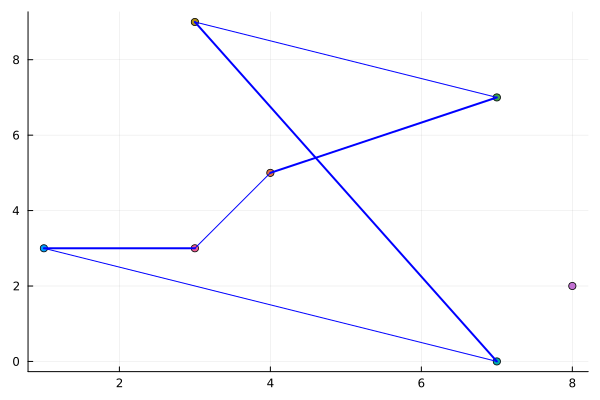

In [8]:
ciclo=zeros(N,N)
ciclo[1,7]=1
ciclo[2,3]=1
ciclo[5,6]=1

ciclo[3,5]=0.5
ciclo[2,7]=0.5
ciclo[1,6]=0.5

dibuja(coordenadax,coordenaday,ciclo)

## P2
Antes de modelar problemas de emparejamientos veamos como hacerlo para un problema genérico de programación lineal.

Sean:
$A = \begin{pmatrix}
1 &2\\
3 &4\\
\end{pmatrix},
B = \begin{pmatrix}
1 &-2\\
0 &-1\\
\end{pmatrix},
a = \begin{pmatrix}
0\\
1\\
\end{pmatrix},
b = \begin{pmatrix}
1\\
-1\\
\end{pmatrix},
c = \begin{pmatrix}
1\\
3\\
\end{pmatrix},
d = \begin{pmatrix}
-2\\
1\\
\end{pmatrix}$

Defina dichos vectores y matrices e implemente la función **creaModelo** que retorna el modelo JuMP del siguiente programa lineal:

\begin{align*}
\textit{(P)}\quad  \min cx+dy\\
Ax &\geq a\\
By & \leq b\\
x & \geq 0\\
y & \in \{0,1\}^2\\
\end{align*}
_Indicación: Puede serle útil consultar la [Documentación de JuMP](https://jump.dev/JuMP.jl/stable/)._

In [9]:
A = [1 2; 3 4]
B = [1 -2; 0 -1]
a = [0; 1]
b = [1; -1]
c = [1 3]
d = [-2 1]

1×2 Matrix{Int64}:
 -2  1

In [10]:
function creaModelo(A,B,a,b,c,d)
    modelo = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV), "OutputFlag" => 0, "Presolve"=>0, "Cuts"=>0, "Heuristics"=>0, "Threads"=>1))
    @variable(modelo, 0<=x[1:2]);
    @variable(modelo, y[1:2], Bin);
    @objective(modelo, Min, sum(c[i]*x[i]+d[i]*y[i] for i in 1:2));
    @constraint(modelo, A*x.>=a);
    @constraint(modelo, B*y.<=b);

    return modelo
end

creaModelo (generic function with 1 method)

In [11]:
modelo = creaModelo(A,B,a,b,c,d)
optimize!(modelo)
display(string("Estado de Término: ", termination_status(modelo)))
display(string("Valor Objetivo: ", objective_value(modelo)))

Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1


"Estado de Término: OPTIMAL"

"Valor Objetivo: -0.6666666666666667"

_Nota: El valor objetivo debería ser alrededor de -0.66666..._

***
En lo que sigue  $G=(V,E)$ es un grafo **completo** con $V=[N]$, Los siguientes cuatro modelos son modelos exactos (posiblemente extendidos y en el sentido de puntos extremos) para encontrar un emparejamiento de peso mínimo. Consideraremos $E=\{[i,j]\colon 1\leq i < j\leq N\}$.


\begin{align*}
\text{(M1)}\quad  \min \sum_{e\in E} x_ew_e\\
x(E) &= N/2\\
x_{e}+x_{f}&\leq 1, \forall e, f \in E\colon |e\cap f|=1\\
0\leq x_e&\leq 1, \forall e\in E\\
x_e&\in \mathbb{Z}, \forall e\in E\\
\mbox{}\\
\text{(M2)}\quad  \min \sum_{e\in E} x_ew_e\\
x(\delta(i))&= 1, \forall i\in V\\
x_e&\geq 0, \forall e\in E\\
x_e&\in \mathbb{Z}, \forall e\in E\\
\mbox{}\\
\text{(M3)}\quad  \min \sum_{e\in E} x_ew_e\\
x(\delta(i))&= 1, \forall i\in V\\
y(V)&=n/2\\
x_{ij}&\leq y_{i}+y_{j}, \forall e=ij \in E\\
x_{ij}&\leq 2-y_{i}+y_{j}, \forall e=ij \in E\\
x_e&\geq 0, \forall e\in E\\
0\leq y_v&\leq 1, \forall v\in V\\
y_v&\in \mathbb{Z}, \forall v\in V\\
\mbox{}\\
\text{(M4)}\quad  \min \sum_{e\in E} x_ew_e\\
x(E) &= N/2\\
x(E(S))&\leq \frac{|S|-1}{2}, \forall S\subseteq V, |S| \text{ impar}\\
0\leq x_e&\leq 1, \forall e\in E\\
\end{align*}

Los 4 modelos son bastante distintos entre sí. 

El primer modelo es un PLE con $m=\Theta(N^2)$ variables enteras y $\Theta(N^3)$ restricciones.

El segundo modelo es un PLE con $m=\Theta(N^2)$ variables enteras y $\Theta(N)$ restricciones (ignorando cotas).

El tercer modelo es un PL Mixto con $m=\Theta(N^2)$ variables continuas, $N$ variables enteras y $\Theta(N^2)$ restricciones.

El cuarto modelo es un PL puro con  $m=\Theta(N^2)$ variables continuas  y $\Theta(2^N)$ restricciones. Un teorema de Edmonds garantiza que los puntos extremos de (M4) son exactamente matchings perfectos.

***

# P3

Implemente la función **emparejamiento** que reciba como entrada:
```julia
num_modelo: entero en {1,2,3,4} que representa si se trabaja con M1, M2, M3 o M4.
N: número de vértices del grafo
w: matriz de pesos
```
y entregue el modelo en juMP/Gurobi asociado al grafo entregado.

In [12]:
function interseccion(e,f)
    if e == f
        return false
    end
    if e[1]==f[1] || e[1]==f[2] || e[2]==f[1] || e[2]==f[2]
        return true
    end
    return false
end

interseccion (generic function with 1 method)

In [13]:
function emparejamiento(num_modelo, N, w)
    modelo = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV), "OutputFlag" => 0, "Presolve"=>0, "Cuts"=>0, "Heuristics"=>0, "Threads"=>1))
    E = [[i,j] for i in 1:N, j in 1:N if i<j]
    if num_modelo==1
        @variable(modelo, 0<=x[E]<=1,Int);
        @objective(modelo, Min, sum(x[e]*w[e[1],e[2]] for e in E));
        @constraints(modelo, begin
            sum(x[e] for e in E) == N//2
            [e in E, f in E; interseccion(e,f)], x[e]+x[f] <= 1
        end)
    end
    if num_modelo==2
        @variable(modelo, 0<=x[e in E],Int);
        @objective(modelo, Min, sum(x[e]*w[e[1],e[2]] for e in E));
        @constraints(modelo, begin
            [i in 1:N], sum(x[[i,j]] for j in i+1:N) + sum(x[[j,i]] for j in 1:i-1) == 1
        end)
    end
    if num_modelo==3
        @variable(modelo, 0<=x[E])
        @variable(modelo, 0<=y[1:N]<=1, Int)
        @objective(modelo, Min, sum(x[e]*w[e[1],e[2]] for e in E));
        @constraints(modelo, begin
            [i in 1:N], sum(x[[i,j]] for j in i+1:N) + sum(x[[j,i]] for j in 1:i-1) == 1
            # Alternativa:
            #[i in 1:N], sum(x[[i,j]] for j in 1:N if [i,j] in E || [j,i] in E) == 1
            sum(y[v] for v in 1:N) == N//2
            [e in E], x[e] <= y[e[1]] + y[e[2]]
            [e in E], x[e] <= 2 - y[e[1]] + y[e[2]]
        end)
    end
    if num_modelo==4
        @variable(modelo, 0<=x[E]<=1)
        @variable(modelo, 0<=y[1:N]<=1, Int)
        @objective(modelo, Min, sum(x[e]*w[e[1],e[2]] for e in E));
        @constraints(modelo, begin
            sum(x[e] for e in E) == N//2
            [S in powerset(1:N); length(S)%2==1], sum(x[e] for e in E if e[1] in S && e[2] in S) <= (length(S)-1)/2
        end)
    end
    return modelo
end

emparejamiento (generic function with 1 method)

Pruebe su método ejecutando el siguiente bloque:

In [14]:
N=6
a = [63, 114, 165, 14, 140, 180]
b = [174, 133, 54, 87, 47, 35]
w = distancias(a,b)

6×6 Matrix{Float64}:
 0.0  65.437  157.493    99.8499  148.519   181.687
 0.0   0.0     94.0319  110.073    89.8443  118.152
 0.0   0.0      0.0     154.564    25.9615   24.2074
 0.0   0.0      0.0       0.0     132.197   173.954
 0.0   0.0      0.0       0.0       0.0      41.7612
 0.0   0.0      0.0       0.0       0.0       0.0

In [15]:
num_mod=1
modelo1=emparejamiento(num_mod, N, w)
optimize!(modelo1)
@show(termination_status(modelo1))
@show(objective_value(modelo1))

Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1
termination_status(modelo1) = MathOptInterface.OPTIMAL
objective_value(modelo1) = 213.90163398561813


213.90163398561813

In [16]:
num_mod=2
modelo2=emparejamiento(num_mod, N, w)
optimize!(modelo2)
@show(termination_status(modelo2))
@show(objective_value(modelo2))

Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1
termination_status(modelo2) = MathOptInterface.OPTIMAL
objective_value(modelo2) = 213.90163398561813


213.90163398561813

In [17]:
num_mod=3
modelo3=emparejamiento(num_mod, N, w)
optimize!(modelo3)
@show(termination_status(modelo3))
@show(objective_value(modelo3))

Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1
termination_status(modelo3) = MathOptInterface.OPTIMAL
objective_value(modelo3) = 213.90163398561816


213.90163398561816

In [18]:
num_mod = 4
modelo4 = emparejamiento(num_mod, N, w)
optimize!(modelo4)
@show(termination_status(modelo4))
@show(objective_value(modelo4))

Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1
termination_status(modelo4) = MathOptInterface.OPTIMAL
objective_value(modelo4) = 213.90163398561816


213.90163398561816

_Nota: El valor objetivo debería ser alrededor de 213.9016339..._

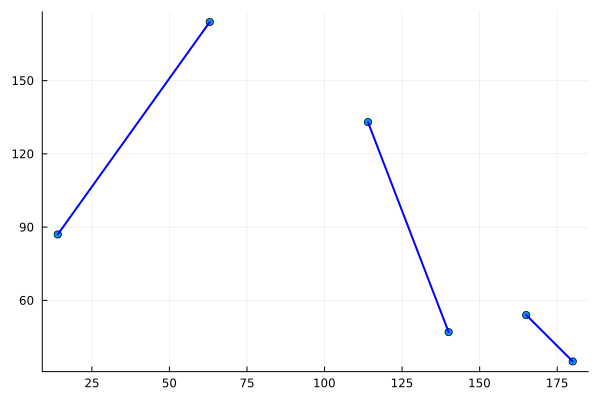

In [19]:
# Celda para dibujar el matching encontrado
X = zeros(N,N)
for i in 1:N, j in 1:N
    if i<j
    X[i,j]=value(modelo4[:x][[i,j]])
    end
end
dibuja(a,b,X)

## [Propuesto] P4

Escriba una función **test_matching(N_MAX)** que realice lo siguiente.

1. Genere una instancia aleatoria (N, coordX,coordY,w) para cada N par entre 6 y N_MAX 
   donde coordX, coordY son puntos de la grilla 1:200 por 1:200 y w es su matriz de distancia.
   
   _Indicación: Puede serle útil usar el comando **sample(1:200, N, replace = false)** entrega N enteros entre 1 y 200 sin repetición._
   
   Guarde las instancias creadas en un arreglo, durante su ejecución pues debe retornarlas al final.

2. Para cada instancia (N,coordX,coordY,w) de su lista y cada modelo (num_mod), calcule y guarde los siguientes valores:
    1. Valor de N
    2. valor de num_mod
    3. Numero de variables del modelo (busque el comando en la documentación de JuMP)
    4. Numero de restricciones del modelo (busque el comando en la documentación de JuMP)
    5. Tiempo de creación del modelo a partir de (N,coordX,coordY,w).   
       _Indicación: Investigue el comando **@elapse**._ 
    6. Tiempo de resolución del modelo creado.
    7. Valor objetivo encontrado (si logró terminar, si no, entregar 0).
       _NOTA: Debe testear si el modelo termina de ejecutar usando **termination_status**._
    8. Numero de iteraciones de simplex realizadas (**JuMP.simplex_iterations(modelo)**)
    9. Numero de nodos BnB realizados (**JuMP.node_count(nombre_modelo)**)
   
   Luego elimine integralidad de las variables del modelo, resuelva nuevamente y calcule
   
    10. Tiempo de resolución del modelo fraccional
    11. Valor objetivo encontrado (si logró terminar, si no, entregar 0)
    12. Numero de iteraciones de simplex realizadas
    
3. Retorne un par INSTANCIAS, TABLA 

Parte 2. Cuando termine su función ejecute **test_matching(8)** y **test_matching(20)**, mostrando la TABLA creada.  

Sugerencia: Un formato razonable de tabla es el de la siguiente celda

In [ ]:
ENV["COLUMNS"]=200
df=DataFrame(
    :N                 => Int64[],
    :num_modelo        => Int64[],
    :variables         => Int64[],
    :restricciones     => Int64[],
    :t_creacion_ent    => Float64[],
    :t_resolucion_ent  => Float64[],
    :valor_ent         => Float64[],
    :simplex_ent       => Int64[],
    :nodos_bnb         => Int64[],
    :t_resolucion_frac => Float64[],
    :valor_frac        => Float64[],
    :simplex_frac      => Int64[]) 
push!(df,[6, 1, 18, 60, 0.55, 1.223, 14.4, 10, 7, 2, 0.33, 5])

In [ ]:
function test_matching(N_MAX)
    # implemente
    return INSTANCIAS, TABLA 
end
    

In [ ]:
# Pruebe su función acá
INSTANCIAS8, TABLA8 = test_matching(8);
TABLA8

In [ ]:
# Pruebe su función acá
INSTANCIAS20, TABLA20 = test_matching(20);
TABLA20